## 셸로우 포커스 만들기

인물사진 모드를 구현한다.  
인물사진 모드란 원하는 피사체를 제외한 배경 이미지를 blur 처리하는 것을 의미하며  
직접적으로 카메라를 이용해 사진을 찍을 때 피사계심도를 이용해서 원하는 피사체의 초점을  
맞추고 다른 피사체들은 흐리하는 효과를 가지고 있다.  
이번 토이프로젝트에서는 <strong><span style = "font-size: 20px">segmentation</span></strong>을 이용해서 원하는 피사체를 인식한뒤 다른 것들은 blur처리를 할 것이다.

## Segmentation?  
segmentation이란 이미지에서 픽셀 단위로 원하는 객체를 추출하는 방법이다. 각 픽셀마다 라벨을 달아주고 같은 라벨은 같은 특징을 가진다고 가정하고 이미지를 추출해 낼 수 있다.  
- ### Semantic segmentation  
사람도 Segmetation을 하는데 물리적 <strong>의미</strong>단위로 인식하는 segmentation을 <strong>Semantic</strong> segmentation, 즉 의미적 segmentation 이라고 한다.  
- ### Instance segmentation  
sematic segmentation은 엄밀히 따지자면 사람이 하는 segmentation과는 거리가 있다. 물론 많은 사람이 밀집해 있는 장소라면 모두 같은 '사람'으로 인식하겠지만, 사람이 적은 곳이라면 한 사람 한 사람 마다 개별 <strong>객체</strong>로 인식하여 인식할 것이다.(안경낀 사람, 모자쓴 사람, 잘생긴 사람, 머리가 짧고 분홍색 티를 입은 근육질의 남자와 같은 식으로) 이와 같은 segmentation을 Instance Segmentation이라고 한다.

위 세그멘테이션을 수행해주는 간단한 알고리즘에는 Watershed Segmentation이 있다.

## Watershed Segmentation  
이미지에서 어떤 영역을 떼어내는 방법 중 가장 간단한 것은 물체 마다의 경계를 나누는 것인데, 이미지에서 pixel 값으로 각 위치의 높고 낮음을 구분할 수 있는 것을 통해 낮은 부분부터 물을 채워 나간다고 생각하면, 물이 넘치는 지점이 있을 것이다. 이 부분을 경계선으로 삼는 것이 watershed segmentation이다.

기본적인 설명들은 끝났으니, 본격적으로 프로젝트를 진행해보도록 한다.  
먼저 프로젝트에 필요한 라이브러리들을 import 해준다.

## 라이브러리 

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 이미지 불러오기 

2
3
4


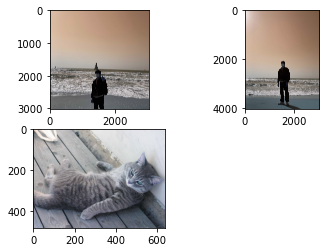

In [2]:
import os

images = []
orig_list = []
col = 2
row = 2


for i in range(1,4):
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image{}.jpg'.format(i)  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
    images.append(img_path)
    img_orig = cv2.imread(img_path)
    orig_list.append(img_orig)
   
    
i = 1

for image in images:
    img = cv2.imread(image)
    plt.subplot(col, row, i)
    i += 1
    print(i)
   
    plt.imshow(img)
    
    
    
plt.show()


segmentation에는 FCN, SegNet, U-Net 등 많은 모델 들이 사용되는데. 이 중에서 높은 성능으로 최근 까지도 이용되고 있는 DeepLab 알고리즘을 구현해보기로 한다.

## DeepLab 모델 구성

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path): #만들어져 있는 DeepLab 모델을 수정하고 불러온다.
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)


    def preprocess(self, img_orig):#전처리를 담당하는 메서드, input tensor로 바꾸어준다.
        
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):#실제로 세그멘테이션을 수행하는 메서드
        img_input = self.preprocess(image)

        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map


## 가중치 불러오기 

사전에 학습된 가중치를 url로 부터 다운받고 불러온다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


temp directory: /home/aiffel-dj16/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
resized_list = []
seg_list = []
for img_orig in orig_list:
    img_resized, seg_map = MODEL.run(img_orig)
    resized_list.append(img_resized)
    seg_list.append(seg_map)
    print(img_orig.shape, img_resized.shape, seg_map.max())

(3024, 3024, 3) (513, 513, 3) 15
(4032, 3024, 3) (513, 384, 3) 15
(480, 640, 3) (384, 513, 3) 8


아래는 PASCAL VOC의 라벨로 학습된 DeepLab에서 제공된 라벨이다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

2
3
4


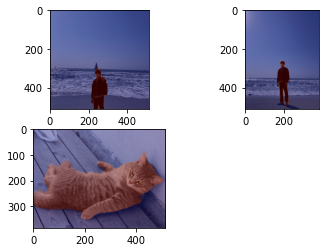

In [7]:
show_list = []
mask_list = []
for i in range(3):
    img_show = resized_list[i].copy()
    if i == 2:
         seg_map = np.where(seg_list[i] == 8, 8, 0) # LABEL_NAMES의 idx 8에 해당하는 고양이만 추출
    else:
        seg_map = np.where(seg_list[i] == 15, 15, 0) # LABEL_NAMES의 idx 15에 해당하는 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    mask_list.append(img_mask)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)#세그멘테이션된 곳에 color를 적용
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    show_list.append(img_show)
    
i = 1

for show in show_list:
#     img = cv2.imread(show)
    
    plt.subplot(col, row, i)
    i += 1
    
    print(i)
   
    plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
    
plt.show()

DeepLab 모델을 사용하기 위해 작게 resize했던 이미지를 원래대로 복원한다.  
좌표축을 보면 original mask 상태의 크기가 늘어난 것을 볼 수 있다.

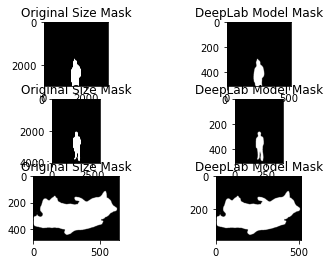

In [8]:
col = 3
row = 2
mask_up_list = []

for i in range(3):
    img_mask_up = cv2.resize(mask_list[i], orig_list[i].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    mask_up_list.append(img_mask_up)

    if i == 0:
        ax = plt.subplot(col,row,i+1)
        plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
        ax.set_title('Original Size Mask')

        ax = plt.subplot(col,row,i+2)
        plt.imshow(mask_list[i], cmap=plt.cm.binary_r)
        ax.set_title('DeepLab Model Mask')
        
    elif i == 1:
        ax = plt.subplot(col,row,i+2)
        plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
        ax.set_title('Original Size Mask')

        ax = plt.subplot(col,row,i+3)
        plt.imshow(mask_list[i], cmap=plt.cm.binary_r)
        ax.set_title('DeepLab Model Mask')
    else:
        ax = plt.subplot(col,row,i+3)
        plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
        ax.set_title('Original Size Mask')

        ax = plt.subplot(col,row,i+4)
        plt.imshow(mask_list[i], cmap=plt.cm.binary_r)
        ax.set_title('DeepLab Model Mask')

plt.show()


사람, 고양이만 사진에서 따로 떼어낸 이미지(=배경)을 만들어준다.

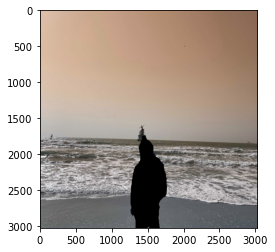

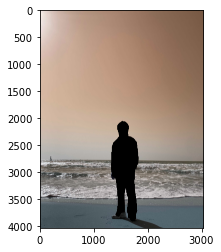

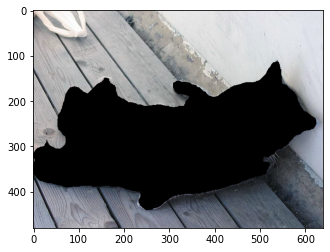

In [9]:
bg_list = []
for i in range(3):
    img_mask_color = cv2.cvtColor(mask_up_list[i], cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(orig_list[i], img_bg_mask)
    plt.imshow(img_bg)
    bg_list.append(img_bg)
    plt.show()

위에서 떼어낸 배경에 흐릿한 효과를 준다

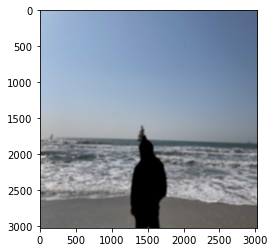

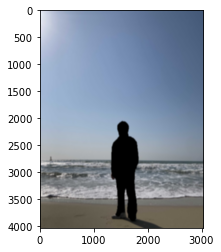

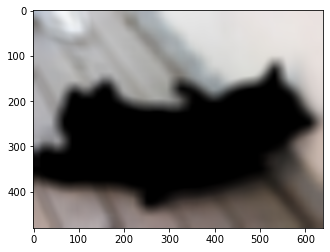

In [10]:
blur_list = []
i = 0
for i in range(3):
    img_bg_blur = cv2.blur(bg_list[i], (30,30)) #좀 더 눈에 띄고 극적인 효과를 위해 30으로 줬다.
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    blur_list.append(img_bg_blur)
    plt.show()


## 합성  
마지막으로 segmentation을 통해 저장해 놓은 사람, 고양이의 이미지와, 흐릿하게 만든 나머지 배경이미지를 합성해준다.

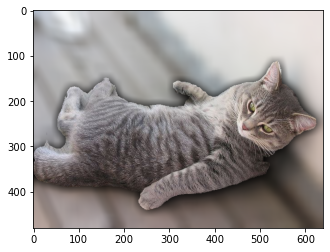

[[[198 184 176]
  [198 184 176]
  [198 184 176]
  ...
  [224 226 234]
  [224 226 234]
  [224 226 234]]

 [[198 184 176]
  [198 184 176]
  [198 184 176]
  ...
  [224 226 234]
  [224 226 234]
  [224 226 234]]

 [[198 183 175]
  [198 183 175]
  [198 183 175]
  ...
  [224 226 234]
  [224 226 234]
  [224 226 234]]

 ...

 [[157 163 182]
  [157 163 182]
  [157 163 182]
  ...
  [ 68  78  91]
  [ 68  78  91]
  [ 68  78  90]]

 [[157 163 182]
  [157 163 182]
  [157 163 182]
  ...
  [ 69  78  91]
  [ 68  78  91]
  [ 68  78  90]]

 [[157 163 182]
  [157 163 182]
  [157 163 182]
  ...
  [ 69  78  91]
  [ 69  78  91]
  [ 68  78  91]]]


In [14]:
img_concat = np.where(img_mask_color==255, orig_list[2], blur_list[2])
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
print(img_concat)


## 회고  
이번 프로젝트는 DEEPLAB을 사용했다. 배경을 떼어내고 흐릿하게 하는데 까지 다른 사진들을 모두 완료했는데 마지막 합성에서 orig의 크기가 갑자기 바뀌는 문제가 있어서 image1과 2는 합성이 되지 않았다.(심지어 크로마키 배경 과제는 마지막에 알아채서 시간이 부족해서 하지못했다) 결과물은 만족스럽지 못한 프로젝트 였지만, 과정 자체가 흥미로웠기 때문에 아쉬움만 남는 프로젝트는 아니었던 것 같다. DEEPLAB의 구조를 뜯어가면서 완벽히 이해하고자 하는 마음은 먹지 않았기 때문에 쉽게 지치지 않고 할 수 있었던 토이프로젝트 였다. 미리 학습된 가중치와 원하는 라벨을 통해서 쉽게 segmentation을 할 수 있었는데, 활용하는 것은 (물론 어느정도의 이해는 필요하겠지만) 크게 어렵지 않을 수 있다는 것을 깨닳았다. 의도치는 않았지만 처음부터 배경가 원하는 목표가 잘 분리되어있는듯한 이미지여서 그랬는지, 눈에 띌만한 문제는 발견되지 않았고 내가 겪은 문제에 대한 해결방안을 제시하는데에는 다소 어려움이 있을 거라는 판단을 내렸다.  
입력데이터가 좋았던 것 뿐이며, 내가 실제로 개입한 파라미터는 크게 없었기 때문에 어차피 겪을 문제라고 생각하고 일반적인 한계와 해결방안에 대해 정리한다.  
- 원하는 목표(물체, 인물)과 함께 포함하고 싶은 부분이 포함되지 않거나, 깊이에 따른 인식을 하지 못할 때  

> Struct2Depth 기법을 이용하여 다른 센서 없이도 깊이를 인식하고, 깊이에 따라 그 목표를 인식할 것인지 정하기 때문에 좋은 해결 방안이 된다.
